# Superhero Social Networking

### Introduction

In this notebook, we will use Python to do some web crawling and text mining on Wikipedia to create a network of characters in the Marvel Universe. You can run each Python cell by selecting the cell and hitting the `Ctrl-Enter` keys on your keyboard.

To begin with, we need a few variables to control the behavior of this notebook.

In [11]:
host = 'https://en.wikipedia.org'
max_articles = 200
max_depth = 3
print "OK"

OK


### Mining for a character list

A Wikipedia articles can lead to a lot of other articles that have nothing to do with Marvel characters. By text mining the Marvel character list articles, we can come up with a list of article URLs belonging to Marvel characters. This takes a while since we *rate limit* page downloads to prevent overloading Wikipedia. Therefore, this code is in a function that can be executed if you uncomment the last line of the code cell. The list has already been saved to the `marvel_urls.txt` text file.

In [12]:
def textmine_marvel_urls():
    import time
    slug = '/wiki/List_of_Marvel_Comics_characters:'
    sections = ['_0-9']
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for char in letters:
        sections.append('_' + char)

    character_urls = list()

    for section in sections:
        time.sleep(1)
        character_list_url = host + slug + section
        print "Downloading " + character_list_url
        page = PyQuery(url=character_list_url)
        hatnotes = page(".hatnote")
        for hatnote in hatnotes:
            noteQuery = PyQuery(hatnote)
            if "Main article" in noteQuery.text():
                link = noteQuery.find("a")
                if link:
                    character_urls.append(link.attr("href"))

    output_file = open('marvel_urls.txt', 'w')

    for url in character_urls:
        output_file.write(url)
        output_file.write("\n")

    output_file.flush()
    output_file.close()

# textmine_marvel_urls()

### Loading a list of Marvel character URLs

Since we already have a list of Marvel URLs stored in a file, we can load it into a list

In [13]:
input_file = open('marvel_urls.txt', 'r')
character_urls = input_file.readlines()
character_urls = [url.strip() for url in character_urls]

print str(len(character_urls)) + " characters total"

2856 characters total


### Culling the list

There are more than 2500 articles related to Marvel characters. Since this network is too large to compute in a reasonable amount of time, let's cut it down to only those that appear in the Marvel Cinematic Universe.

In [14]:
from pyquery import PyQuery

mcu_article = PyQuery(url="https://en.wikipedia.org/wiki/List_of_Marvel_Cinematic_Universe_film_actors")
mcu_html = mcu_article.html()

shorter_list = []
for url in character_urls:
    if url in mcu_html:
        shorter_list.append(url)
        
character_urls = shorter_list

mcu_file = open("mcu_articles.txt", "w")
for url in character_urls:
    mcu_file.write(url)
    mcu_file.write("\n")

mcu_file.close()

print str(len(character_urls)) + " characters in the Marvel Cinematic Universe"

127 characters in the Marvel Cinematic Universe


### Mining an Article

If we retrieve a Wikipedia article about a character, we need to mine the data from it to see which Marvel Cinematic Universe characters it links to. The `Article` class listed below takes care of these details. It downloads a page given a URL, performs text mining to determine the title of the page, and fills its `links` member with a link to new `Article` objects with Marvel Cinematic Universe articles, to be crawled.

In [15]:
from pyquery import PyQuery


class Article:
    links = None
    depth = 0
    from_url = ""
    url = ""
    page_contents = None
    from_character = None
    character = ""
    
    def __init__(self, **kwargs):
        self.links = list()
        self.depth = 0
        self.from_url = ""
        self.url = ""
        self.page_contents = None
        self.from_character = None
        self.character = ""
        if "from_url" in kwargs:
            self.from_url = kwargs["from_url"]
        if "url" in kwargs:
            self.url = kwargs["url"]
        if "depth" in kwargs:
            self.depth = kwargs["depth"]
        if "from_character" in kwargs:
            self.from_character  = kwargs["from_character"]
        if "character" in kwargs:
            self.character = kwargs["character"]
    
    def __str__(self):
        result = "Destination: " + self.url
        if self.character:
            result = result = " (" + self.character + ")"
        return result

    def __eq__(self, other):
        return self.url == other.url
    
    def __ne__(self, other):
        return not self == other
            
    def loadPage(self):
        full_url = host + self.url
        self.page_contents = PyQuery(url=full_url)
        self.character = self.page_contents("h1").text()       
        if self.depth < max_depth:
            for a in self.page_contents("a"):
                aQuery = PyQuery(a)
                href = aQuery.attr("href")
                if href and href.startswith("/wiki/") and href in character_urls:
                    self.links.append(Article(from_url=self.url, url=href, from_character=self.character, depth=self.depth + 1))
            
print "OK"

OK


### Crawling the Articles on Wikipedia

Now we need to crawl the articles and save link information. This `Crawler` class will crawl articles, given a starting point. By default, it chooses Iron Man as a starting point.

To crawl, we have a `crawl_queue` which contains `Article` objects to process and a list of all URLs we have already queued. When the `Crawler` class is instantiated, it starts with the starting `Article` as the only item in the `crawl_queue`. We dequeue the each `Article` and tell it to retrieve its contents. After retrieval, we save the `Article` using the `register_article` function. For each `Article` in the dequeued article's `links` member, if the `Article` URL is not already in our queued list, we enqueue it back into our `crawl_queue` and save the URL in our list of queued articles. 

To avoid having to repeat the process, which is time consuming and bandwidth consuming, we can save the data in a json file.

In [16]:
import time
import networkx as nx
import json
from collections import deque

class Crawler:
    start_article = None
    crawl_queue = None
    visited = None
    data = None
    
    def __init__(self, start_url = "/wiki/Iron_Man"):
        self.queued = list()
        self.crawl_queue = deque()
        self.data = dict()
        self.visited = list()
        self.start_article = Article(url=start_url)
        self.crawl_queue.append(self.start_article)
    
    def register_article(self, article):
        entry = dict()
        entry["character"] = article.character
        entry["links"] = list()
        for link in article.links:
            entry["links"].append(link.url)
        self.data[article.url] = entry
    
    def print_article(self, article):
        result = "Processed " + article.character
        if article.from_character:
            result = result + " (from " + article.from_character +")"
        result = result + " with " + str(len(article.links)) + " links"
        print result
        
    def save_data(self, filename="article_data.json"):
        with open(filename, 'w') as f:
            json.dump(self.data, f)
        
    def crawl_articles(self):
        while len(self.crawl_queue) > 0 and len(self.visited) < max_articles:
            time.sleep(2)
            
            article = self.crawl_queue.popleft()
            
            article.loadPage()
            self.register_article(article)
            self.print_article(article)
            self.visited.append(article)
            count = 0
            for link in article.links:
                if link not in self.crawl_queue and link not in self.visited:
                    count = count + 1
                    self.crawl_queue.append(link)
            print str(count) + " new links queued"
            

# Uncomment these lines to mine articles and save data
#crawler = Crawler(start_url="/wiki/Iron_Man")
#crawler.crawl_articles()
#crawler.save_data()

### Edge Matrix

Now we need to keep track of connections between characters. We can do this using a weighted Edge Matrix. Simply put, it's a table where the rows are a character, and the columns of each row count the number of connections to the corresponding character. 

In [17]:
class EdgeMatrix:
    edge_map = []
    url_indexes = dict()
    url_names = dict()
    urls = list()
    
    def __init__(self):
        pass
    
    def add_url(self, url):
        for row in self.edge_map:
            row.append(0)
        self.edge_map.append([0 for x in range(1, len(self.edge_map) + 2)])
        self.url_indexes[url] = len(self.edge_map) - 1
        self.urls.append(url)
    
    def mark_edge(self, from_item, to_item):
        if from_item.url not in self.url_indexes:
            self.add_url(from_item.url)
        if to_item.url not in self.url_indexes:
            self.add_url(to_item.url)
        from_index = self.url_indexes[from_item.url]
        to_index = self.url_indexes[to_item.url]
        self.edge_map[ from_index ][ to_index ] = self.edge_map[ from_index ][ to_index] + 1
        
        if from_item.url not in self.url_names or not self.url_names[from_item.url]:
            self.url_names[from_item.url] = from_item.character
        
        if to_item.url not in self.url_names or not self.url_names[to_item.url]:
            self.url_names[to_item.url] = to_item.character
            
    def get_name(self, index):
        return self.url_names[self.urls[index]]
    
print "OK"

OK


### Populating the Edge Matrix

Now that we have the link data and some where to store it, we need to fill the Edge Matrix. The `data` dictionary is filled with the article data from the file we saved from web crawling earlier. To populate it, we visit each url in `data` and create `from_article`, which is an instance of an `Article`. Then we re-create an `Article` from each link, and save it as `to_article`. Finally, we register each edge using these two articles.

In [18]:
import json

data = None

with open('article_data.json', 'r') as f:
    data = json.load(f)

edges = EdgeMatrix()

for url in data:
    from_article = Article(character=data[url]["character"], url=url)
    for link in data[url]["links"]:
        to_article = Article(url=link)
        edges.mark_edge(from_article, to_article)
        
print "OK"

OK


### Visualizing the Social Network

We can create a visual representation of the network from the edges that we saved. By traversing the list of edges, recording the "weight" between each edge (the number of links from one article to another article, such as from Iron Man to Pepper Potts) and the degree of each node (the number of links from an article, such as from Iron Man to any other article) we can create a graph where the colors communicate additional information to us.

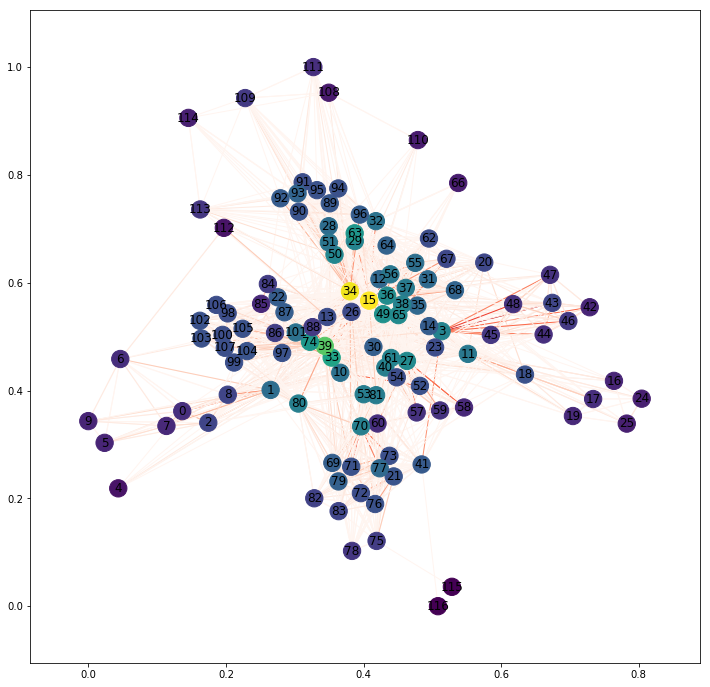

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

import networkx as nx
graph = nx.DiGraph()
edge_map = edges.edge_map
length = len(edges.edge_map)


for row in range(0, length):
    for col in range(0, length):
        if edge_map[row][col] > 0:
            graph.add_edge(row, col, weight=edge_map[row][col])

weights = [ d["weight"] for (u, v, d) in graph.edges(data=True)]
degrees = nx.degree(graph).values()

node_color_map = plt.cm.viridis
edge_color_map = plt.cm.Reds
    
if not len(weights):
    weights = 'k'
    
if not len(degrees):
    sizes = 300
    
if len(degrees):
    vmin = min(degrees)
    vmax = max(degrees)
else:
    vmin = 0
    vmax = 0
    
if len(weights):
    edge_vmin = min(weights)
    edge_vmax = max(weights)
else:
    edge_vmin = 0
    edge_vmax = 0
    
plt.figure(1, figsize=(12, 12))
nx.draw_networkx(graph, pos=nx.random_layout(graph), vmin=vmin, vmax=vmax, with_labels=True,edge_color=weights, node_color=degrees, edge_vmin=edge_vmin, edge_vmax=edge_vmax, edge_cmap=edge_color_map, cmap=node_color_map, arrows=False)
plt.show()

### Analyzing the Network

Your eye may be drawn to certain nodes because of the coloring of the nodes. The nodes that are brightest have the highest degrees. They are the most interconnected. Let's look at those node names

In [32]:
interesting = [ 34, 15, 33, 39 ]

for node in interesting:
    print node, edges.get_name(node)


34 Iron Man
15 Captain America
33 Hulk (comics)
39 Thor (Marvel Comics)


### Edge weights

Your eye may also be draw to heavily weighted edges. This illustrates strong connections between characters. Let's look at two nodes with dark red lines.

In [34]:
interesting = [ 3, 48 ]

for node in interesting:
    print node, edges.get_name(node)

3 Spider-Man
48 Vulture (Marvel Comics)
